# HatLab Parameters
Generating Fidelity Landscapes using the HatLab experimental parameters.

$\alpha = 4.54 \, \text{GHz}$

$\delta = -190 \, \text{MHz}$

We turn $\delta$ and $\alpha$ from frequencies to angular frequencies. Additionally, our amplitude is now also angular.

In [3]:
import sys
sys.path.append("..")
import importlib
import numpy as np
import matplotlib.pyplot as plt
import qutip

import system.theoretical2pi as system
importlib.reload(system)
import utils.solver as solver
importlib.reload(solver)
import pulse.tukey as pulse_gen
importlib.reload(pulse_gen)
import utils.expectation_values as expect
importlib.reload(expect)

pass

In [4]:
from qutip.parallel import parallel_map as parallel_map
from qutip.parallel import parfor as parfor
from tqdm import tqdm
all_results = []
_amp = 2.5 * 2 * np.pi
_off = 0
_dur = 35

In [5]:
def run_once(dur):
    global _amp, _off
    tlist = np.linspace(0, dur, int(dur*2))
    pulse_gen.setup(amplitude=_amp, drive_frequency= system.first_energy_spacing/3 - _off, ramp_coef=0.2, tlist=tlist)
    solution = solver.time_evolve(H_d=system.H0, H_c=system.H1, pertubation_func=pulse_gen.pulse_func, tlist=tlist, starting_state=system.basis_states[0], pbar=False)
    expectation_values = expect.get_all_expectation_values(solution.states, system.basis_states)
    return {
        "fidelity": expectation_values[1][-1],
        "offset": _off,
        "frequency":  system.first_energy_spacing/3 - _off,
        "duration": dur,
        "amplitude": _amp
    }

In [6]:
iterations = 150
for i in tqdm(range(0, iterations)):
    _off = np.linspace(0.0001, 0.4, iterations)[i]
    already_did_this_offset = False
    for result in all_results:
        if result["offset"] == _off:
            already_did_this_offset = True
            break
    if already_did_this_offset:
        continue

    all_results += parallel_map(run_once, np.linspace(4, 500, 50)) # durations here

100%|██████████| 150/150 [1:38:07<00:00, 39.25s/it]


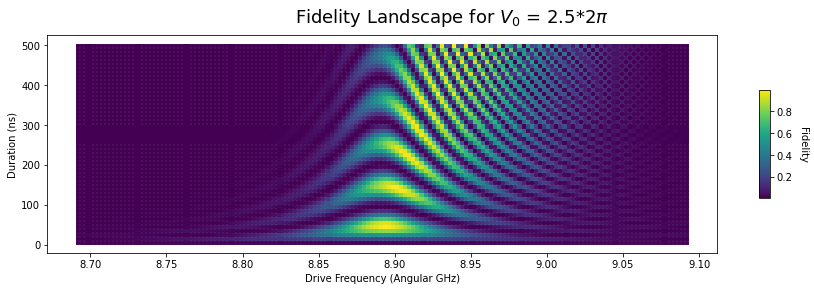

In [62]:
import copy
# %matplotlib widget

amps = []
offs = []
durs = []
fids = []
freqs = []
all_results_to_graph = copy.deepcopy(all_results)
for result in all_results_to_graph:
    amps.append(result["amplitude"])
    offs.append(result["offset"])
    durs.append(result["duration"])
    fids.append(result["fidelity"])
    result["frequency"] = system.first_energy_spacing/3 - result["offset"]
    freqs.append(result["frequency"])


fig, axs = plt.subplots(figsize=(15, 4))
fig.suptitle("Fidelity Landscape for $V_0$ = %.1f$ * 2\pi$" % (amps[-1]/(2*np.pi)), fontsize=18)
axs.set_xlabel("Drive Frequency (Angular GHz)")
axs.set_ylabel("Duration (ns)")
surf = axs.scatter(freqs, durs, c=fids, cmap="viridis", marker="s", s=10)
cbar = fig.colorbar(surf, shrink=0.5, aspect=10)
cbar.ax.set_ylabel("Fidelity", rotation=270)
cbar.ax.get_yaxis().labelpad = 15
# axs.pcolormesh(offs, durs, fids)

In [69]:
for i in range(0,9): #using "full" cosine
    print((system.energies[i] - system.energies[i+1])/ (2*np.pi))

-4.341002778350152
-4.128774455947205
-3.881222186023324
-2.7354807742090625
-0.9419347006499778
-4.070244705612489
-3.018295289849864
-5.221861647052118
-4.261994973873627


In [71]:
for i in range(0,9): #using truncated power series
    print((system.energies[i] - system.energies[i+1])/ (2*np.pi))

-4.35
-4.16
-3.9699999999999975
-3.7800000000000025
-3.5900000000000016
-3.399999999999992
-3.210000000000005
-3.02
-2.829999999999999


In [39]:
import utils.saver as saver

saver.save(all_results, "correct_2pi_2-5_landscape")

## Solve over many V0s

In [6]:
super_set_of_results = []
_amp = 2.5 * 2 * np.pi
for amp in tqdm(np.linspace(2.5*2*np.pi, 5.5*2*np.pi, 25)):
    global _amp
    _amp = amp
    iterations = 50
    for i in range(0, iterations):
        _off = np.linspace(0.1, 0.3, iterations)[i]
        already_did_this_offset = False
        for result in super_set_of_results:
            if result["amplitude"] == _amp and result["offset"] == _off:
                already_did_this_offset = True
                break
        if already_did_this_offset:
            continue

        super_set_of_results += parallel_map(run_once, np.linspace(4, 500, 35)) # durations here
    print(super_set_of_results[-1])

  4%|▍         | 1/25 [26:19<10:31:44, 1579.37s/it]

{'fidelity': 0.0016801180363514839, 'offset': 0.3, 'frequency': 8.8106186954104, 'duration': 500.0, 'amplitude': 15.707963267948966}


  8%|▊         | 2/25 [59:21<11:36:18, 1816.44s/it]

{'fidelity': 0.0026753276563985635, 'offset': 0.3, 'frequency': 8.8106186954104, 'duration': 500.0, 'amplitude': 16.493361431346415}


 12%|█▏        | 3/25 [1:24:33<10:15:04, 1677.46s/it]

{'fidelity': 0.022225275497315258, 'offset': 0.3, 'frequency': 8.8106186954104, 'duration': 500.0, 'amplitude': 17.27875959474386}


 16%|█▌        | 4/25 [1:50:59<9:34:27, 1641.31s/it] 

{'fidelity': 0.16648341978705192, 'offset': 0.3, 'frequency': 8.8106186954104, 'duration': 500.0, 'amplitude': 18.06415775814131}


 20%|██        | 5/25 [2:19:02<9:12:06, 1656.32s/it]

{'fidelity': 0.11362460130216662, 'offset': 0.3, 'frequency': 8.8106186954104, 'duration': 500.0, 'amplitude': 18.84955592153876}


 24%|██▍       | 6/25 [2:45:41<8:38:19, 1636.80s/it]

{'fidelity': 2.7432663035692902e-05, 'offset': 0.3, 'frequency': 8.8106186954104, 'duration': 500.0, 'amplitude': 19.634954084936208}


capi_return is NULL
capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.
capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.
Call-back cb_f_in_zvode__user__routines failed.
 24%|██▍       | 6/25 [3:14:20<10:15:24, 1943.41s/it]


KeyboardInterrupt: 

## Smart Generate Graph for V0

In [20]:
_dur = 50
_dur_max = 200
_amp = 2.5 * 2 * np.pi
_off = 0.3
_results = []

def vary_offset(off):
    global _dur, _amp, _off, _results, _dur_max
    tlist = np.linspace(0, _dur, int(_dur*2))
    pulse_gen.setup(amplitude=_amp, drive_frequency= system.first_energy_spacing/3 - off, ramp_coef=0.2, tlist=tlist)
    solution = solver.time_evolve(H_d=system.H0, H_c=system.H1, pertubation_func=pulse_gen.pulse_func, tlist=tlist, starting_state=system.basis_states[0], pbar=False)
    expectation_values = expect.get_all_expectation_values(solution.states, system.basis_states)
    return {
        "fidelity": expectation_values[1][-1],
        "offset": off,
        "frequency":  system.first_energy_spacing/3 - off,
        "duration": _dur,
        "amplitude": _amp
    }

def single_amp_run(amp):
    global _dur, _amp, _off, _results, _dur_max
    _amp = amp
    offs_to_test = np.linspace(_off-0.01, _off+0.01, 50)
    offset_varying_results = parfor(vary_offset, offs_to_test)
    _fids_off_sweep = []
    for result in offset_varying_results:
        _fids_off_sweep.append(result["fidelity"])
    _off = offset_varying_results[np.argmax(_fids_off_sweep)]["offset"]
    iterations = 75
    for i in tqdm(range(0, iterations)):
        _off = np.linspace(_off-0.1, _off+0.1, iterations)[i]
        already_did_this_offset = False
        for result in _results:
            if result["amplitude"] == _amp and result["offset"] == _off:
                already_did_this_offset = True
                break
        if already_did_this_offset:
            continue

        _results += parallel_map(run_once, np.linspace(4, _dur_max, 35)) # durations here

In [21]:
single_amp_run(2.5*2*np.pi) # will be stored in _results

100%|██████████| 75/75 [13:15<00:00, 10.61s/it]


In [22]:
single_amp_run(2.6*2*np.pi) # will be stored in _results
single_amp_run(2.7*2*np.pi) # will be stored in _results
single_amp_run(2.8*2*np.pi) # will be stored in _results

100%|██████████| 75/75 [10:51<00:00,  8.68s/it]


# Animate Through Amplitudes

{16.336281798666924, 16.964600329384883, 17.59291886010284, 15.707963267948966}
2205
2485
2485
2485


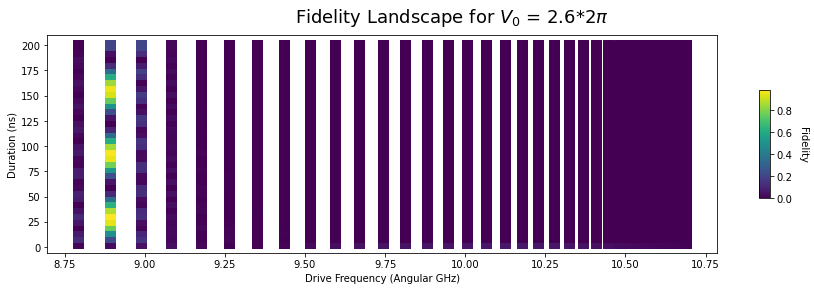

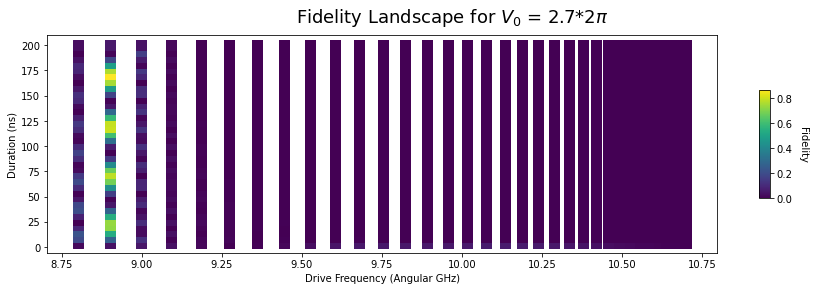

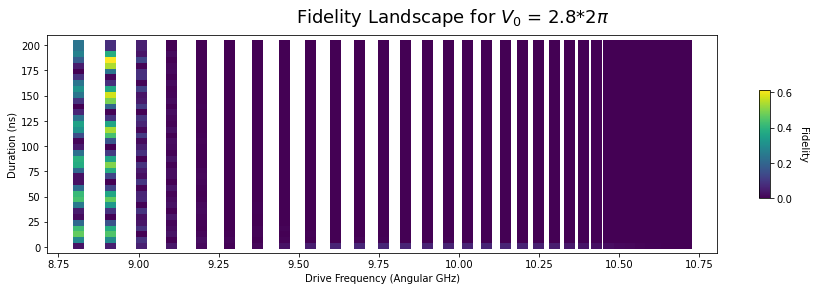

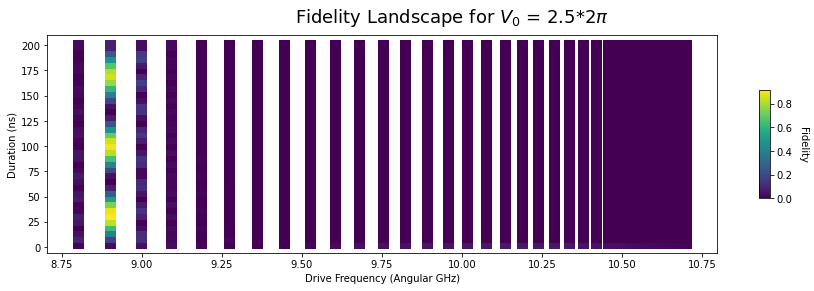

In [24]:
import copy
# %matplotlib widget

amps = []
offs = []
durs = []
fids = []
freqs = []
all_results_to_graph = copy.deepcopy(_results)
for result in all_results_to_graph:
    amps.append(result["amplitude"])
meta_amps = set(amps)
print(meta_amps)

for amp in meta_amps:
    offs = []
    durs = []
    fids = []
    freqs = []
    for result in all_results_to_graph:
        # print(result["amplitude"])
        # print(amp)
        # input()
        if result["amplitude"] == amp:
            offs.append(result["offset"])
            durs.append(result["duration"])
            fids.append(result["fidelity"])
            freqs.append(result["frequency"])
    fig, axs = plt.subplots(figsize=(15, 4))
    fig.suptitle("Fidelity Landscape for $V_0$ = %.1f$ * 2\pi$" % (amp/(2*np.pi)), fontsize=18)
    axs.set_xlabel("Drive Frequency (Angular GHz)")
    axs.set_ylabel("Duration (ns)")
    print(len(offs))
    surf = axs.scatter(freqs, durs, c=fids, cmap="viridis", marker="s", s=100)
    cbar = fig.colorbar(surf, shrink=0.5, aspect=10)
    cbar.ax.set_ylabel("Fidelity", rotation=270)
    cbar.ax.get_yaxis().labelpad = 15
    plt.plot()
# axs.pcolormesh(offs, durs, fids)


# from matplotlib import pyplot as plt
# from matplotlib import animation

# # meta_amps = [2.5, 2.6, 2.7, ...]

# import copy

# meta_amps =[]
# for result in all_results_to_graph:
#     meta_amps.append(result["amplitude"])
# meta_amps = set(meta_amps)
# print(meta_amps)
# # fig, axs = plt.subplots(figsize=(15, 4))
# # fig.suptitle("Fidelity Landscape for $V_0$ = %.1f$ * 2\pi$" % (amps[-1]/(2*np.pi)), fontsize=18)
# # axs.set_xlabel("Drive Frequency (Angular GHz)")
# # axs.set_ylabel("Duration (ns)")
# # surf = axs.scatter(freqs, durs, c=fids, cmap="viridis", marker="s", s=10)
# # cbar = fig.colorbar(surf, shrink=0.5, aspect=10)
# # cbar.ax.set_ylabel("Fidelity", rotation=270)
# # cbar.ax.get_yaxis().labelpad = 15
# # # axs.pcolormesh(offs, durs, fids)

# fig = plt.figure()

# points = plt.scatter([],[], s=100)

# def init():
#     return points

# def animate(i):
#     #i is index of amp
#     amp = meta_amps[i]
#     fig.suptitle("Fidelity Landscape for $V_0$ = %.1f$ * 2\pi$" % (amp/(2*np.pi)), fontsize=18)

#     offs = []
#     durs = []
#     fids = []
#     freqs = []
#     for result in all_results_to_graph:
#         if result["amplitude"] == amp:
#             offs.append(result["offset"])
#             durs.append(result["duration"])
#             fids.append(result["fidelity"])
#             freqs.append(result["frequency"])

#     points = plt.scatter(freqs, durs, c=fids, marker="s", s=100)

#     return points #return everything that must be updated

# anim = animation.FuncAnimation(fig, animate, init_func=init,
#                                frames=100, interval=20, blit=True)

# plt.show()

# Try Full Cosine

In [68]:
import system.theoretical2piReverted as system # change system to full cosine system we reverted back to
importlib.reload(system)

<module 'system.theoretical2piReverted' from '../system/theoretical2piReverted.py'>

In [41]:
all_results2 = []

In [64]:
iterations = 100
for i in tqdm(range(0, iterations)):
    _off = np.linspace(0.1, 0.3, iterations)[i]
    already_did_this_offset = False
    for result in all_results2:
        if result["offset"] == _off:
            already_did_this_offset = True
            break
    if already_did_this_offset:
        continue

    all_results2 += parallel_map(run_once, np.linspace(4, 200, 20)) # durations here

100%|██████████| 100/100 [10:04<00:00,  6.05s/it]


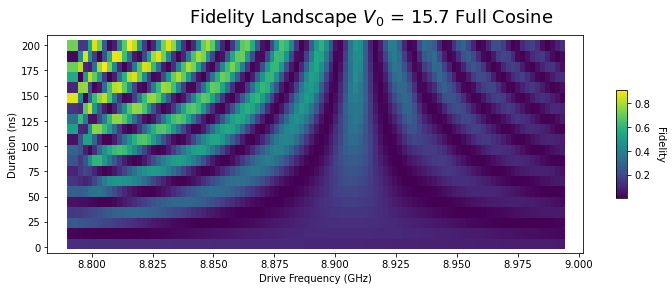

In [65]:
import copy
# %matplotlib widget

amps = []
offs = []
durs = []
fids = []
freqs = []
all_results_to_graph = copy.deepcopy(all_results2)
for result in all_results_to_graph:
    amps.append(result["amplitude"])
    offs.append(result["offset"])
    durs.append(result["duration"])
    fids.append(result["fidelity"])
    result["frequency"] = system.first_energy_spacing/3 - result["offset"]
    freqs.append(result["frequency"])


fig, axs = plt.subplots(figsize=(12, 4))
fig.suptitle("Fidelity Landscape $V_0$ = %.1f Full Cosine" % amps[-1], fontsize=18)
axs.set_xlabel("Drive Frequency (GHz)")
axs.set_ylabel("Duration (ns)")
surf = axs.scatter(freqs, durs, c=fids, cmap=None, marker="s", s=100)
cbar = fig.colorbar(surf, shrink=0.5, aspect=10)
cbar.ax.set_ylabel("Fidelity", rotation=270)
cbar.ax.get_yaxis().labelpad = 15
# axs.pcolormesh(offs, durs, fids)

In [44]:
import utils.saver as saver

saver.save(all_results2, "theoretical_landscape_2-5_fullcosine_no2pi")